<a href="https://colab.research.google.com/github/Tom-McDonald/studynotebooks/blob/master/Chapter_3_Exercises_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 3 - Classification
---

* **1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the `KNeighborsClassifier` works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
`weights` and `n_neighbors` hyperparameters).**

Firstly, we import the necessary libraries/functions and load the dataset directly from scikit-learn. Then we split the data into training and test sets (this is done already in the dataset; the first 60000 instance are training data and the last 10000 are test), and shuffle the training data so that there aren't too many instances of the same number together, which can affect model performance. 

In [0]:
import numpy as np
import os
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(42)                                                               # makes notebook output reproducible across runs

def sort_by_target(mnist):                                                       # function is required as 'fetch_openml returns' the unsorted MNIST data
    reorder_train = np.array(sorted([(target, i) for i, target in \
                                     enumerate(mnist.target[:60000])]))[:, 1]    # 'sort_by_target' makes the dataset the same as is used in the book
    reorder_test = np.array(sorted([(target, i) for i, target in  \
                                     enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)                                      # fetch_openml() returns targets as strings
sort_by_target(mnist)                                                            # fetch_openml() returns an unsorted dataset

X, y = mnist["data"], mnist["target"]
print('Shape of MNIST data: ', X.shape)
print('Shape of MNIST target data: ', y.shape)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Shape of MNIST data:  (70000, 784)
Shape of MNIST target data:  (70000,)


Now we use the the `KNeigborsClassifier` to classify the digits. This would typically be done using `GridSearchCV`, but this takes hours to fit, so I completed the code to the exercise and then just looked up the `best_params_` in the exercise answers in order to save time. The grid search code is therefore block commented out.

In [0]:
# from sklearn.model_selection import GridSearchCV

# knn = KNeighborsClassifier(n_jobs=-1)

# params = {
#         'n_neighbors':[3, 4, 5],
#         'weights':['uniform', 'distance']
# }

# grid_cv = GridSearchCV(knn, params, cv=3, verbose=18, n_jobs=-1)
# grid_cv.fit(X_train, y_train)
# y_pred = grid_cv.predict(X_train, y_train)
# print(accuracy_score(y_train, y_pred))

knn = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)
print('Accuracy score of KNN on test set is: ', knn_acc)

Accuracy score of KNN on test set is:  0.9714


* **2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of 
artificially growing the training set is called *data augmentation* or *training set expansion*. **

The digit below has the target value of 9


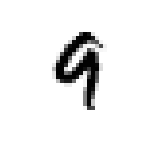

In [0]:
def plot_digit(image):                                                           # function to plot digits, each consists of a 28x28 pixel array which we must shift
    image = image.reshape((28, 28))
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')

plot_digit(X_train[40000])
print('The digit below has the target value of', y_train[40000])

The function below takes an input of a string, 'up', 'down', 'left' or 'right' to shift each image in the training set one pixel in the given direction, creating four new datasets of 60,000 images each. The new augmented training set therefore is 300,000 (5*60,000) images long, with the corresponding number of target variables.

In [0]:
def shift_mnist_images(direction, X_train):
    X_train_shift = np.copy(X_train)
    if direction == 'up':
        shift_vert = -1
        shift_horiz = 0
    elif direction == 'down':
        shift_vert = 1
        shift_horiz = 0
    elif direction == 'left':
        shift_vert = 0
        shift_horiz = -1
    elif direction == 'right':
        shift_vert = 0
        shift_horiz = 1
    for i in range(len(X_train_shift)):
        image = X_train_shift[i]
        image = image.reshape((28,28))
        image = np.roll(image, (shift_vert, shift_horiz), axis=(0,1))
        image = image.reshape(784,)
        X_train_shift[i] = image
    return(X_train_shift)

print(X_train.shape, 'is the shape of the original training set.')
print(y_train.shape, 'is the shape of the original training targets.\n')
X_train_up = shift_mnist_images('up', X_train)
X_train_down = shift_mnist_images('down', X_train)
X_train_left = shift_mnist_images('left', X_train)
X_train_right = shift_mnist_images('right', X_train)

X_train_aug = np.concatenate([X_train, X_train_up, X_train_down, X_train_left,
                             X_train_right])
y_train_aug = np.concatenate([y_train, y_train, y_train, y_train, y_train])
print(X_train_aug.shape, 'is the shape of the augmented training set.')
print(y_train_aug.shape, 'is the shape of the augmented training targets.')

(60000, 784) is the shape of the original training set.
(60000,) is the shape of the original training targets.

(300000, 784) is the shape of the augmented training set.
(300000,) is the shape of the augmented training targets.


This augmented training data can now be fed back into the KNN model to improve the accuracy of the predictions. Augmenting the training set in this fashion has lead to a ~0.5% increase in accuracy.

In [0]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)
knn.fit(X_train_aug, y_train_aug)
y_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)
print('Accuracy score of KNN on test set is: ', knn_acc)

Accuracy score of KNN on test set is:  0.9763


* **3. Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). **

Firstly I downloaded the data via the Kaggle API, instructions for using the API on Colab can be found [here.](https://colab.research.google.com/drive/1DofKEdQYaXmDWBzuResXWWvxhLgDeVyl#scrollTo=0hyJ4Rb5HMwH) 

In [0]:
from google.colab import files                                                   # manually upload the kaggle.josn API key file, download from 'My Account' on Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tommcd","key":"2fb26ed7071c6de5e2dd0164a3e0ef90"}'}

In [0]:
!pip install -q kaggle                                                           # install Kaggle API client and move API key to correct path
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 24.1MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 27.3MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.50MB/s]


In [0]:
!pip install sklearn-pandas
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as ss

train = pd.read_csv('train.csv', header=0, index_col=0)
test = pd.read_csv('test.csv', header=0, index_col=0)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


After downloading the data, we can separate the target variable and begin to preprocess the data before modelling.

In [0]:
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
print(X_train.info())
print(X_train.describe())

X_train = X_train.drop('Ticket', axis=1)                                         # dropping 'Ticket' fields 
X_test = test.drop('Ticket', axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB
None
           Pclass         Age       SibSp       Parch        Fare
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118    0.523008    0.381594   32.204208
std      0.836071   14.526497    1.102743    0.806057   49.693429
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   20.125000    0.000000    0.000000    7.910400
50%      3.000000   28.000000    0.000000    0.000000   14.454200
75%      3.000000   38.000000    1.000000    0

From the above information, we can see that we'll likely need to impute some age values using `Imputer`. *Ticket*  has been dropped from the dataset as these unique identifiers likely won't help us much in classifying the passengers (in any non-complex fashion at least).

*Embarked, Pclass, Parch, SibSp* and *Sex* must be one-hot encoded as these are categorical variables. For reasons explained [here on Stack Overflow](https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values), I used `pd.get_dummies` to do this as opposed to `OneHotEncoder` from `scikit-learn`, as the latter can't deal with unseen categorical values in the test set, whereas with `get_dummies` we can simply ignore this unseen variable.

We can also create classes to do some basic feature engineering, here we'll use the *Cabin* column to determine whether a passenger has a cabin or not, and we'll create a new feature equal to the length of the *Name* field string.

In [0]:
class name_length_feature(BaseEstimator, TransformerMixin):                      # creating transformers for adding new features to the data
    def __init__(self, add_name_length=True):                                    # replacing 'Name' with 'name_length' and 'Cabin' with 'has_cabin',
        self.add_name_length = add_name_length
    def fit(self, X):
        return self
    def transform(self, X):
        X['name_length'] = X['Name'].apply(len)
        return X.drop('Name', axis=1)

class has_cabin_feature(BaseEstimator, TransformerMixin):
    def __init__(self, add_has_cabin_feature=True):
        self.add_has_cabin_feature = add_has_cabin_feature
    def fit(self, X):
        return self
    def transform(self, X):
        X['has_cabin'] = pd.notnull(X['Cabin'])
        return X.drop('Cabin', axis=1)

class categorical_encoding(BaseEstimator, TransformerMixin):
    def __init__(self, encode=True):
        self.encode = encode
    def fit(self, X):
        return self
    def transform(self, X):
        X_dummies = pd.get_dummies(pd.DataFrame(X))
        return X_dummies

num_pipeline = Pipeline([                                                        # creating separate pipelines for numerical and categorical features,
        ('imputer', SimpleImputer(strategy='median')),                           # then combining them using ColumnTransformer
        ('scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', categorical_encoding())
    ])

num_attribs = ['Age', 'Fare', 'name_length']
cat_attribs = ['Pclass', 'Sex', 'SibSp', 'Parch', 'has_cabin', 'Embarked']

combined_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ('cat', cat_pipeline, cat_attribs),
    ])

full_pipeline = Pipeline([                                                       # combining the ColumnTransformer pipeline with the feature engineering
        ('add_has_cabin', has_cabin_feature()),
        ('add_name_length', name_length_feature()),
        ('num_cat_pipeline', combined_pipeline)
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

After putting the pipeline together to prepare the data, we can fit a Support Vector Classifier (SVC) to the training set and make some predictions on the test data, before submitting this to Kaggle.

In [0]:
svc = SVC(kernel='linear', C=100, gamma=0.001)
svc.fit(X_train_prepared, y_train)
y_pred = svc.predict(X_train_prepared)
svc_score = accuracy_score(y_train, y_pred)
print('Accuracy of predictions on training set:', svc_score)

X_test_prepared = np.delete(X_test_prepared, 16, axis=1)                         # this deletion was necessary to remove two categorical instances of '9' in the test
y_pred_test = svc.predict(X_test_prepared)                                       # data which were unseen in the training data, hence giving the arrays different dimensions
submission = pd.DataFrame(y_pred_test, index=test.index)
submission.columns = ['Survived']
submission.to_csv('titanic_submission_28012019.csv')
submission.head()

Accuracy of predictions on training set: 0.8024691358024691


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


This inital submission came out at **76.6% accuracy placing around 7,000th on the leaderboard**. Doing some cross validation and hyperparameter tuning should improve this by quite a bit.

In [0]:
rfc = RandomForestClassifier(n_estimators=100)

param_dist = {'n_estimators':ss.randint(50,1000), 
              'min_samples_split':ss.randint(2, 10), 
              'min_samples_leaf':ss.randint(1,4)}

rand_cv = RandomizedSearchCV(rfc, param_distributions=param_dist, 
                                   n_iter=10, cv=5, 
                                   scoring='neg_mean_squared_error', 
                                   return_train_score=True, n_jobs=-1, 
                                   verbose=True)

rand_cv.fit(X_train_prepared, y_train)
y_pred = rand_cv.predict(X_train_prepared)
rfc_score = accuracy_score(y_train, y_pred)
print('Accuracy of predictions on training set:', rfc_score)
y_pred_test = rand_cv.predict(X_test_prepared)                                       # data which were unseen in the training data, hence giving the arrays different dimensions
submission = pd.DataFrame(y_pred_test, index=test.index)
submission.columns = ['Survived']
submission.to_csv('titanic_submission2_28012019.csv')


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.0s finished


Accuracy of predictions on training set: 0.936026936026936


Cross validation via a randomized grid search yielded a slightly better result, with an **accuracy of 77% moving up the leaderboard by ~1000 places**.


* **4. Build a spam classifier (a more challenging exercise):**
>* Download examples of spam and ham from Apache SpamAssassin’s public datasets.
>* Unzip the datasets and familiarize yourself with the data format.
>* Split the datasets into a training set and a test set.
>* Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector
indicating the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
>* You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
>* Then try out several classifiers and see if you can build a great spam classifier,
with both high recall and high precision.

In [0]:
import tarfile
import os
import pandas as pd
import urllib.request
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from bs4 import BeautifulSoup
from sklearn.metrics import precision_score, recall_score

urllib.request.urlretrieve(
    "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2",    # scraping the files from the Apache website
    'spam.tar.bz2')
urllib.request.urlretrieve (
    "https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2",
    'spam_2.tar.bz2')
urllib.request.urlretrieve(
    "https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2",
    'hard_ham.tar.bz2')
urllib.request.urlretrieve(
    "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2",
    'easy_ham.tar.bz2')
urllib.request.urlretrieve(
    "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2",
    'easy_ham_2.tar.bz2')

('easy_ham_2.tar.bz2', <http.client.HTTPMessage at 0x7fe367323780>)

In [0]:
spam = tarfile.open('spam.tar.bz2').extractall()                                 # opening all the .tar files so the individual emails are accessible
spam_2 = tarfile.open('spam_2.tar.bz2').extractall()
hard_ham = tarfile.open('hard_ham.tar.bz2').extractall()
easy_ham = tarfile.open('easy_ham.tar.bz2').extractall()
easy_ham_2 = tarfile.open('easy_ham_2.tar.bz2').extractall()

Now the files are extracted and in our file system, we can get to work on reading the individual emails into Python.

In [0]:
def read_emails(parent_folder):
    emails = []
    for filename in os.listdir(parent_folder):
        file_path = parent_folder + '/' + filename
        file = open(file_path, 'r', encoding = "ISO-8859-1")
        content = file.read()
        emails.append(content)
    return emails

spam = read_emails('spam')
spam_2 = read_emails('spam_2')
easy_ham = read_emails('easy_ham')
easy_ham_2 = read_emails('easy_ham_2')
hard_ham = read_emails('hard_ham')

all_spam = spam + spam_2
all_ham = easy_ham + easy_ham_2 + hard_ham
print('We now have', len(all_spam), 'spam emails and', len(all_ham), 
      'ham emails to use for training and evaluating a model.')

We now have 1898 spam emails and 4153 ham emails to use for training and evaluating a model.


In [0]:
all_emails = all_spam + all_ham
target = (len(all_spam)*[1]) + (len(all_ham)*[0])
df = pd.DataFrame({'is_spam': target, 'email': all_emails})
df = df.sample(frac=1, random_state=123).reset_index(drop=True)                                    # this line shuffles the df randomly, keeping all of the rows (i.e. frac=1)

train, test = train_test_split(df, test_size=0.2, random_state=123)
X_train, X_test = train['email'].tolist(), test['email'].tolist()
y_train, y_test = train['is_spam'].tolist(), test['is_spam'].tolist()

print(len(X_train), 'emails in training set.')

4840 emails in training set.


Now we have shuffled lists containing all the emails (as strings) and the target variables classifying them as spam (1) or ham (0). Using `train_test_split` I've set aside 20% of the data as a test set and separated the target variable from the email in both sets, so now work on the preparation pipeline can begin.

Using `CountVectorizer` from `sklearn`, we can create sparse vectors of how many occurences there are of every single word in every email. It turns out there are around 165,000 unique words in the training set and after these will effectively act as our features for training a classifier. It makes sense to just keep this data in sparse format as scikit-learn can deal with data like this; converting half a billion data points to a dense format would be memory intensive.

I created four transformers to try out on the data, the first replaces all numbers in the text with the string 'NUMBER', the second does the same thing for URLs, the third strips all the superfluous HTML code away from the email and finally the fourth converts all text in the email to lowercase.

In [0]:
class replace_numbers(BaseEstimator, TransformerMixin):                          # creating transformers for adding new features to the data
    def __init__(self, replace_numbers=True):                                    # 1) replacing numbers in text with 'NUMBER'
        self.replace_numbers = replace_numbers
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:] = [re.sub("\d+", " NUMBER ", email) for email in X]
        return X
    
class urls_removed(BaseEstimator, TransformerMixin):
    def __init__(self, urls_removed=True):                                       # 2) replacing all URLs in text with 'URL'
        self.urls_removed = urls_removed
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:] = [re.sub(r'http\S+', 'URL', email) for email in X]
        return X
    
class strip_html(BaseEstimator, TransformerMixin):
    def __init__(self, strip_html=True):                                         # 3) strip HTML code away leaving just the text
        self.strip_html = strip_html
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:] = [BeautifulSoup(email).get_text() for email in X]
        return X
    
class lowercase(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True):                                          # 4) convert email to lowercase
        self.lowercase = lowercase
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X[:] = [email.lower() for email in X]
        return X

text_pipe = Pipeline([
        ('number_replacer', replace_numbers()),
        ('url_remover', urls_removed()),
        ('html_stripper', strip_html()),
        ('lowercase', lowercase()),
        ('vectorizer', CountVectorizer()),
        ('lrc', LogisticRegression(random_state=123))
    ])

Having created the pipeline of transformers finished off with a classifier, we can perform cross validation and check that using these transformers is actually beneficial to the model. A Logistic Regression Classifier has been used here as it's a robust but easy to use algorithm which doesn't require scaling.

In [0]:
param_grid = {
        'number_replacer__replace_numbers': [True, False],
        'url_remover__urls_removed':[True, False],
        'html_stripper__strip_html':[True, False],
        'lowercase__lowercase':[True, False]
}

feature_search = GridSearchCV(text_pipe, param_grid, cv=3, verbose=True,
                             n_jobs=-1)
feature_search.fit(X_train, y_train)
train_acc = accuracy_score(y_train, feature_search.predict(X_train))
test_acc = accuracy_score(y_test, feature_search.predict(X_test))

print(feature_search.best_params_)
print(train_acc, 'is the accuracy of the classifier on the training set.')
print(test_acc, 'is the accuracy of the classifier on the test set.')

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'html_stripper__strip_html': True, 'lowercase__lowercase': True, 'number_replacer__replace_numbers': True, 'url_remover__urls_removed': True}
1.0 is the accuracy of the classifier on the training set.
0.9851362510322048 is the accuracy of the classifier on the test set.


As we can see from the Grid Search, the preprocessing steps all improve the model as they are all present in the final selection. The best model returned gives a 98.5% accuracy rate which is pretty good for a fairly basic pipeline. Improvements could be made by stemming words in the email, removing the header or pulling specific information from the header, such as the subject line.

The precision and recall scores were similarly good, both around 97.5%.



In [0]:
precision = precision_score(y_test, feature_search.predict(X_test))
recall = recall_score(y_test, feature_search.predict(X_test))

print('Precision score on test set:', precision)
print('Recall score on test set:', recall)

Precision score on test set: 0.9745042492917847
Recall score on test set: 0.9745042492917847
